# AGN Catalog Toolbox (ACT) Encapsulated Testing

Welcome to the example notebook showing the AGN Catalog Toolbox (Testing) code in action. This notebook is hopefully a useful explanation of how you can use this code with minimal extra effort. The main author of this code is **Chris Marsden** (c.marsden@soton.ac.uk), but also **Dr Francesco Shankar** (f.shankar@soton.ac.uk) and **Dr Viola Allevato** (viola.allevato@sns.it). Please email me if you have any questions - but be aware that the code is fully documented with docstrings and comments, so you may be able to find your answers in the code itself. 

**Our aim: Create a robust AGN mock catalog.** 

Let's do it.

### Imports

In [1]:
from AGNCatalogToolbox import TestingFramework # The main code
from AGNCatalogToolbox import Literature # Extra code for quick access to scaling relations

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

The ACT is really two 'layers' of tools. The first is a series of functions that do all the things that people would expect. These are located within "main.py". For easy testing and encapulation, these are 'wrapped' in an object based framework that is contained within TestingFramework.py. **This notebook explains the use of the latter framework.**

## Section 1: Creating the Catalog

The first step is to create a 'catalog' object. This is empty for now, but it won't remain like that for long.

### Inititalize catalog

In [2]:
redshift = 0
catalog = TestingFramework.AGNCatalog(redshift)

**We just created the catalog object and set the redshift.** This has no data yet, so the first thing we need to do is populate it with a dark matter catalog.

### Create Dark Matter Catalog

**We have two options here.** The first option is to **create our own semi-analytic catalog** by pulling haloes out of the halo mass function for a volume of our choice, the second is to **load in a simulation catalog** if we want 3D coordiantes, or satallite/parent info etc - see main.load_halo_catalog for the exact details of the required schema. Tools for processing these catalogs can also be found in BigData/.

We can immedately do our first 'check' of this data, by plotting the **halo mass function (HMF)**. Note that if we use the semi_analytic catalog, the comparison with the colossus (Tinker+08) HMF is perfect, as we are using the colossus HMF to generate these haloes in the first place! Simulation data may exhibit some differences.

Loading Dark Matter Catalog
Searching for file...
Found file: MD_0.069.npy
dtypes found:  [('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('id', '<i8'), ('upid', '<i8'), ('mvir', '<f4'), ('First_Acc_Scale', '<f4'), ('First_Acc_Mvir', '<f4')]
Starting the sorting of data
    Sorting halos by upId
    Copying all 114449732 elements with up_id = -1
    Sorting remaining list by main id
    Copying remaining 16310296 elements
Values:  [0. 0. 0. ... 0. 0. 0.]


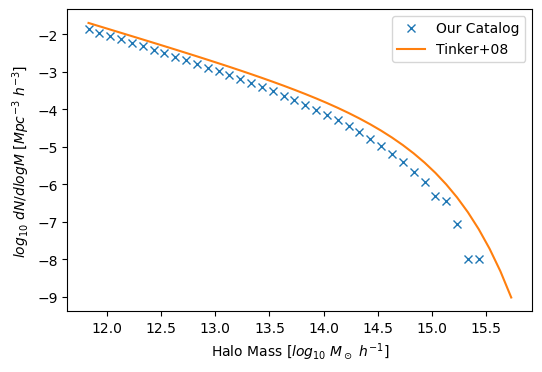

In [3]:
catalog.generate_semi_analytic_halos(500**3, (10, 18, 0.1)) 
# The arguments here are:
# The volume of the catalog we want to create
# The mass range (low, high, spacing)
#catalog.load_dm_catalog() # alternatively the dark matter catalog would be loaded in like this.

# The dark matter data could be easily accessed (in numpy array format) by simply calling e.g.
print("Values: ", catalog.main_catalog["parent_halo_mass"])

# To sanity check these values, we can plot the halo mass function. The framework has it's own fn for this.
hmf, x, chmf, cx = catalog.get_hmf(np.arange(12, 16, 0.1), return_colossus=True)
# The return_colossus argument requests a third argument, the colossus hmf

# Plotting of the HMF
plt.figure(dpi=100)
plt.plot(x, hmf, 'x', label="Our Catalog") 
plt.plot(cx, chmf, label="Tinker+08")
plt.xlabel("Halo Mass [$log_{10}$ $M_\odot$ $h^{-1}$]")
plt.ylabel("$log_{10}$ $dN/dlogM$ [$Mpc^{-3}$ $h^{-3}$]")
plt.legend()
plt.show()

### Assign Stellar Mass and Black Hole mass
It's as simple as:

In [4]:
catalog.assign_stellar_mass(formula="Grylls19", scatter=0.11)  
# These are all the default parameters, shown anyway for completeness.
catalog.assign_black_hole_mass("Shankar16")

# We can easily access them like this:
print("Stellar Masses: {}".format(catalog.main_catalog["stellar_mass"]))
print("BH Masses: {}".format(catalog.main_catalog["black_hole_mass"]))

Stellar Masses: [11.90165   9.149445  9.138124 ... 10.183363  8.553804  9.178934]
BH Masses: [8.737852  2.161478  1.9721428 ... 5.152211  0.9315749 2.5835433]


### Example of catalog cut - keep black holes with masses > 3

Say we want to make a cut to the whole catalog based on some criteria. We can do this as follows:

In [5]:
print("Original catalog has", len(catalog.main_catalog), "galaxies")

flag = catalog.main_catalog["black_hole_mass"] > 3
catalog.main_catalog = catalog.main_catalog[flag]

print("Post-cut, we have", len(catalog.main_catalog), "galaxies")

Original catalog has 130760028 galaxies
Post-cut, we have 27743062 galaxies


Not the most radical cut, but it demonstrates the point.

### Example of catalog cut - reduce volume

A more 'radical' approach is to cut the catalog by volume. Obviously this only works for the simulation catalog, but we need to correct the objects volume or some calculations may not work later. This is a slightly more advanced cut, so feel free to ignore this if you're just starting out. 

In [6]:
# Obviously not relevant for semi-analytic catalog - uncomment if using the simulation catalog

#limit = 500 # Mpc/h
#flag = (obj.main_catalog['x'] < limit) * (obj.main_catalog['y'] < limit) * (obj.main_catalog['z'] < limit)
#obj.main_catalog = obj.main_catalog[flag]
#obj.volume = (limit/obj.h)**3

This obviosuly results in significantly fewer galaxies.

### Getting Eddington Ratio and X-Ray Luminosity

The eddington ratio and X-Ray luminoisty, assigned using black hole mass, are assigned next:

In [7]:
catalog.assign_luminosity_eddington_ratio("Schechter", -0.5, -0.5)

print("X-Ray Luminosity:", catalog.main_catalog["luminosity"])
print("Eddington Ratio: ", catalog.main_catalog["Eddington_Ratio"])

X-Ray Luminosity: [42.314022 37.537933 38.922672 ... 41.8528   37.74442  39.307934]
Eddington Ratio:  [-3.4227097 -2.765488  -2.7085502 ... -2.8715837 -3.2109933 -3.1222634]


We can test this by plotting the X-Ray Luminosity Function in a second.

### Duty Cycle and Column Density

We next calculate the duty cycle (or the probabilty of a black hole being active), and the column density of the AGN, which we will later use for obscuration purposes.

In [8]:
catalog.assign_duty_cycle("Man16")
print("Duty Cycle:", catalog.main_catalog["duty_cycle"])

catalog.assign_nh ()
print("Nh:", catalog.main_catalog["nh"])

Duty Cycle: [0.12757576 0.00151515 0.0014082  ... 0.0921414  0.00103183 0.02107202]
Nh: [28.8977   27.205084 26.819035 ... 26.919514 27.339645 26.006355]


And we're done. But this needs to be validated

## Section 2: Validating the catalog

In this section we provide show examples of how to compare the catalog with known scaling relations.

### Making the cut

To enable an 'apples to apples' comparison, we need to 'crop' our dataset so we only have type 1 and 2 AGN. However, we want to keep a copy of the original dataset to enable comparison...

In [9]:
type12_catalog = TestingFramework.AGNCatalog(redshift) # Create a second catalog object to hold reduced data
type12_catalog.volume = catalog.volume

flag = (catalog.main_catalog["luminosity"] > 41.) * \
       (catalog.main_catalog["nh"] >= 20) *\
       (catalog.main_catalog["nh"] <= 24)

type12_catalog.main_catalog = catalog.main_catalog[flag]

### Example: P(AGN)

This is the probability of a galaxy being active as a function of X-Ray luminosity and stellar mass.

Warning - we have requested redshift 0 - Selecting file Geo17z0.25.csv as it is closest
Warning - we have requested redshift 0 - Selecting file Bon16z0.25.csv as it is closest
Warning - we have requested redshift 0 - Selecting file Bon12z0.25.csv as it is closest
Warning - we have requested redshift 0 - Selecting file Aird12z0.25.csv as it is closest


/Users/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


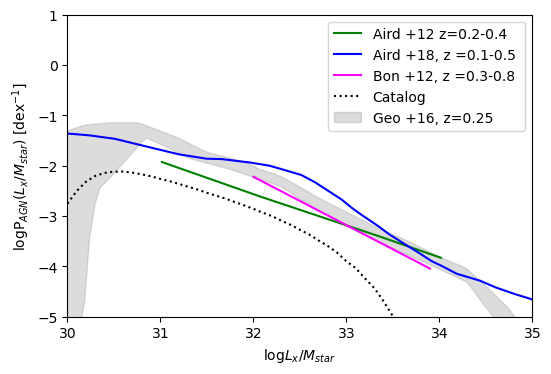

In [10]:
step = 0.1

lg_edd_derived = type12_catalog.main_catalog['luminosity'] - (type12_catalog.main_catalog['stellar_mass'] - 0.15)

edd_bin = np.arange(30, 36.5, step)

prob_derived = stats.binned_statistic(lg_edd_derived, type12_catalog.main_catalog['duty_cycle'], 'sum',
                                         bins=edd_bin)[0] / (sum(type12_catalog.main_catalog['duty_cycle']))*step

EddData = Literature.EddingtonDistributionData(redshift)
BHARAird = (10.**EddData.Aird12.x)/( (500.*25.)/1.3e38 )
BHARAird18 = (10.**EddData.Aird.x)/( (500.*25.)/1.3e38 )

plt.figure(dpi=100)
BHARGeo = (10.**EddData.Geo.x)/( (500.*25.)/1.3e38 )
plt.fill_between(np.log10(BHARGeo), EddData.Geo.yu, EddData.Geo.yd, color="darkgrey",alpha=0.4, label = "Geo +16, z=0.25")

line4, = plt.plot(np.log10(BHARAird), EddData.Aird12.y, color="green", label = "Aird +12 z=0.2-0.4")
line6, = plt.plot(np.log10(BHARAird18), np.log10(EddData.Aird.y), color="blue", label = "Aird +18, z =0.1-0.5 ")

# Bon 12
BHAR = np.arange(32,34.,0.1)
edd = (10.**BHAR)*( (500.*25.)/1.3e38 )
gamma = 0.96
A = 10. ** (29.50)
prob = A*((10.**BHAR ) ** -gamma)
prob = prob*0.1
line5, = plt.plot((BHAR), np.log10(prob),color="magenta", label = "Bon +12, z =0.3-0.8 ")

plt.xlabel("log$L_x/M_{star}$")
plt.ylabel("logP$_{AGN}$($L_x/M_{star}$) [dex$^{-1}$]")

plt.plot(edd_bin[:-1], np.log10(prob_derived), 'k:', label='Catalog')


plt.legend()
plt.xlim((30, 35.))
plt.ylim((-5., 1.))
plt.show()



### Example analysis: Stellar Mass function

We compare the Stellar Mass function of galaxies that are type 1 and 2 AGN with the overall SMF of the catalog. Please note that this is incomplete: Viola is working on the comparison with data here.

/Users/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


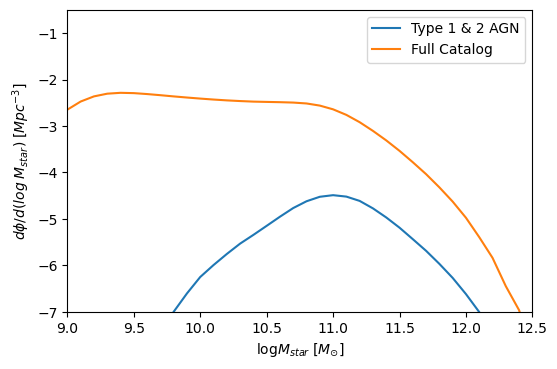

In [11]:
plt.figure(dpi=100)
fbk = {'lw':0.0, 'edgecolor':None}

fn, domain = type12_catalog.get_function("stellar_mass", np.arange(9, 13, 0.1))
plt.plot(domain, np.log10(fn), label = "Type 1 & 2 AGN")
fn, domain = catalog.get_function("stellar_mass", np.arange(9, 13, 0.1), weight=False)
plt.plot(domain, np.log10(fn), label = "Full Catalog")

plt.axis([9, 12.5, -7,-0.5])

plt.legend()

plt.xlabel(r'log$M_{star}\;[M_{\odot}]$')
plt.ylabel(r'$d\phi /d(log\;M_{star})\;[Mpc^{-3}]$')

plt.show()

### X-Ray Luminoisity Function

Next, we compare the AGN Luminosity function to the data.

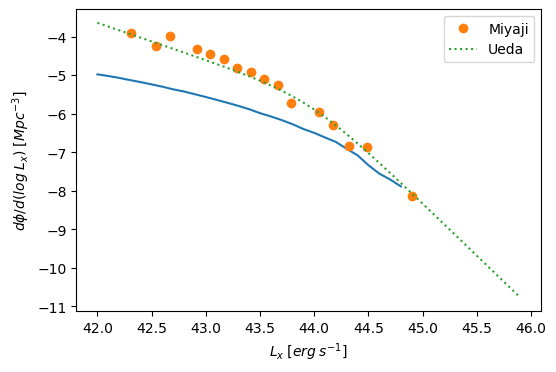

In [12]:
plt.figure(dpi=100)
xlf, domain = type12_catalog.get_function("luminosity", np.arange(42, 45, 0.1))
plt.plot(domain, np.log10(xlf))

XLF = Literature.XLFData(redshift)
mXLF_data = XLF.get_miyaji2015()
plt.plot(np.log10(mXLF_data.x), np.log10(mXLF_data.y), 'o', label = "Miyaji")
uXLF_data = XLF.get_ueda14(np.arange(42, 46, 0.1))
plt.plot(np.log10(uXLF_data.x), np.log10(uXLF_data.y), ':', label = "Ueda")

plt.xlabel(r'$L_x\;[erg\;s^{-1}]$')
plt.ylabel(r'$d\phi /d(log\;L_x)\;[Mpc^{-3}]$')

plt.legend()

plt.show()

### WP

### Bias

### HOD